# The thinking behind this code
Here, I'm just looking to combine the JEDI catalog with the CDAW CME catalog. I really only care about the CME speed and mass in CDAW, so I strip my dataframe down to just that. 
By "combine" I really mean that I'd like to see which EVE emission lines (or line combos) are most predictive of CME speed and mass. I'd like to use some machine learning techniques to accomplish this. 
Combining the two catalogs also means matching the CMEs in CDAW to the rows I have in JEDI (or putting in null values where CDAW doesn't have a corresponding CME). 

In [2]:
# Standard modules
import numpy as np
import pandas as pd
from astropy.time import Time
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns

# Custom modules
from jpm_time_conversions import *
from jpm_logger import JpmLogger
%matplotlib inline
sns.set()
plt.style.use('jpm-dark')

## First things first: I've got to read in the catalogs and do a bit of cleaning
and then take a look at the resultant dataframes

In [3]:
# Read in the JEDI and CDAW catalogs
jedi = pd.read_hdf('/Users/jmason86/Dropbox/Research/Postdoc_NASA/Analysis/Coronal Dimming Analysis/JEDI Catalog/jedi_v2.h5', key='jedi')
cdaw = pd.read_csv('/Users/jmason86/Dropbox/Research/Data/CDAW/Historical CME Data.csv', parse_dates=[['Date', 'Time']])

In [4]:
# Clean the CDAW catalog, strip out the columns I don't care about, convert to numeric data type wherever appropriate
cdaw.index = pd.DatetimeIndex(cdaw['Date_Time'])
cdaw.index.rename('Datetime', inplace=True)
cdaw.drop(['Date_Time', 'KE [erg]'], inplace=True, axis=1)
cdaw = cdaw.convert_objects(convert_numeric=True)

/Users/jmason86/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [5]:
# More cleaning: restricting the time range of CDAW to that of JEDI
cdaw = cdaw[jedi['GOES Flare Start Time'][0]: jedi['GOES Flare Start Time'][len(jedi) - 1]]
cdaw.head()

,Position Angle [º],Width,Linear Speed [km/s],Mass [g],Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
Datetime,,,,,,,,,,,,,,
2010-05-04 18:30:05,341.0,21,425.0,5.200000e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-05 00:30:05,232.0,15,259.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-05 13:31:45,333.0,7,519.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-05 17:06:05,331.0,25,462.0,1.200000e+14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-05 17:54:05,236.0,23,231.0,7.000000e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
jedi.tail()

,Event #,GOES Flare Start Time,GOES Flare Peak Time,GOES Flare Class,Pre-Flare Start Time,Pre-Flare End Time,Flare Interrupt,Flare Latitude [deg],Flare Longitude [deg],Flare Position Angle [deg],...,103.2 by 63.0 Fitting Score,103.2 by 71.9 Fitting Score,103.2 by 72.2 Fitting Score,103.2 by 77.0 Fitting Score,103.2 by 79.0 Fitting Score,103.2 by 83.6 Fitting Score,103.2 by 95.0 Fitting Score,103.2 by 97.3 Fitting Score,103.2 by 97.7 Fitting Score,103.2 by 102.6 Fitting Score
5046,5047,2014-04-15 06:31:00,2014-04-15 06:36:00,C1.0,2014-04-14 22:17,2014-04-15 03:17,True,-999,-999,134.999999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5047,5048,2014-04-15 06:42:00,2014-04-15 06:47:00,C3.6,2014-04-14 22:17,2014-04-15 03:17,True,-999,-999,134.999999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5048,5049,2014-04-15 07:04:00,2014-04-15 07:09:00,C1.3,2014-04-14 22:17,2014-04-15 03:17,True,-15,-27,119.054603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5049,5050,2014-04-15 08:53:00,2014-04-15 08:57:00,C1.3,2014-04-14 22:17,2014-04-15 03:17,True,-18,-8,156.037511,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5050,5051,2014-04-15 09:15:00,2014-04-15 09:23:00,C8.6,2014-04-14 22:17,2014-04-15 03:17,True,-14,-25,119.248825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some postfacto cleaning here... JEDI >v1 will have GOES event latitude and longitude included but v1 doesn't so I need to bolt that on. 

In [7]:
from scipy.io.idl import readsav
goes_flare_events = readsav('/Users/jmason86/Dropbox/Research/Data/GOES/events/GoesEventsC1MinMegsAEra.sav')

In [8]:
jedi.insert(4, 'GOES Latitude', np.nan)
jedi.insert(5, 'GOES Longitude', np.nan)

In [9]:
goes_peak_times_to_add = Time(goes_flare_events['event_peak_time_jd'], format='jd', scale='utc').iso
for i in range(len(jedi)):
    matched_indices = np.where(goes_peak_times_to_add == jedi['GOES Flare Peak Time'][i])
    if len(matched_indices[0]) > 0:
        if goes_flare_events['latitude'][matched_indices[0][0]] != -999:
            jedi['GOES Latitude'][i] = goes_flare_events['latitude'][matched_indices[0][0]][0]
            jedi['GOES Longitude'][i] = goes_flare_events['longitude'][matched_indices[0][0]][0]

## Make a merged catalog (DataFrame)
I am using JEDI as the baseline and will fill in what I can from CDAW. This merged set will of course contain columns in addition to what's in JEDI.

In [10]:
jedicdaw = jedi.copy()
jedicdaw['Has CME'] = False
jedicdaw['Matching CME time to time of'] = np.nan
jedicdaw['CME Time'] = np.nan
jedicdaw['CME Width [º]'] = np.nan
jedicdaw['CME Speed [km/s]'] = np.nan
jedicdaw['CME Mass [g]'] = np.nan

## Matching up rows in JEDI and CDAW
To match up the rows in the two catalogs, I am using the standard that Alysha Reinard is, but slightly modified for my case: an event is correlated if the CME CDAW start time is between 2 hours before and 4 hours after the dimming max depth time (mean across emission lines) and within 45º of the flare location (converted to position angle). 

First I'll just define a function to convert flare position in lat/lon to position angle so it can be directly compared with the CME CDAW position

In [11]:
def lat_lon_to_position_angle(longitude, latitude):
    """Function to translate heliocentric coordinates (latitude, longitude) into position angle
    Written by Alysha Reinard. 
    
    Inputs:
        longitude [float]: The east/west coordinate
        latitude [float]: The north/south coordinate
        
    Optional Inputs:
       None

    Outputs:
        position_angle [float]: The converted position angle measured in degrees from solar north, counter clockwise
                                                 
    Optional Outputs:
        None

    Example:
        position_angle = lat_lon_to_position_angle(35, -40)    
    """
    x = longitude * 1.0
    y = latitude * 1.0
    if y != 0:
        pa = np.arctan(-x / y)
    else:
        pa = 3.1415926 / 2.  # limit of arctan(infinity)

    pa = pa * 180.0 / 3.1415926

    if y < 0:
        pa += 180
    if x == 90 and y == 0:
        pa += 180
    if pa < 0:
        pa += 360
        
    if x == 0 and y == 0:
        pa = -1

    return pa

Just to make sure the function isn't buggy, I'll assert some values to sanity check them

In [12]:
assert lat_lon_to_position_angle(0, 0) == -1 # halo
assert lat_lon_to_position_angle(0, -90) == 180 # straight down
assert lat_lon_to_position_angle(0, 90) == 0 # straight up
assert lat_lon_to_position_angle(-90, 0) == 90 # to the left [east]
assert lat_lon_to_position_angle(90, 0) == 270 # to the right [west]

Now I'll compute position angle based on GOES lon, lat and add that as a new JEDI column

In [13]:
jedi.insert(6, 'GOES Converted Position Angle [º]', np.nan)

In [14]:
for i in range(len(jedi)):
    jedi['GOES Converted Position Angle [º]'].iloc[i] = lat_lon_to_position_angle(jedi['GOES Longitude'].iloc[i], jedi['GOES Latitude'].iloc[i]) # value setting on copy warning is ok.. the new computes values do show up in original jedi variable

/Users/jmason86/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
jedi.tail()

,Event #,GOES Flare Start Time,GOES Flare Peak Time,GOES Flare Class,GOES Latitude,GOES Longitude,GOES Converted Position Angle [º],Pre-Flare Start Time,Pre-Flare End Time,Flare Interrupt,...,103.2 by 63.0 Fitting Score,103.2 by 71.9 Fitting Score,103.2 by 72.2 Fitting Score,103.2 by 77.0 Fitting Score,103.2 by 79.0 Fitting Score,103.2 by 83.6 Fitting Score,103.2 by 95.0 Fitting Score,103.2 by 97.3 Fitting Score,103.2 by 97.7 Fitting Score,103.2 by 102.6 Fitting Score
5046,5047,2014-04-15 06:31:00,2014-04-15 06:36:00,C1.0,NaN,NaN,NaN,2014-04-14 22:17,2014-04-15 03:17,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5047,5048,2014-04-15 06:42:00,2014-04-15 06:47:00,C3.6,NaN,NaN,NaN,2014-04-14 22:17,2014-04-15 03:17,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5048,5049,2014-04-15 07:04:00,2014-04-15 07:09:00,C1.3,NaN,NaN,NaN,2014-04-14 22:17,2014-04-15 03:17,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5049,5050,2014-04-15 08:53:00,2014-04-15 08:57:00,C1.3,NaN,NaN,NaN,2014-04-14 22:17,2014-04-15 03:17,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5050,5051,2014-04-15 09:15:00,2014-04-15 09:23:00,C8.6,NaN,NaN,NaN,2014-04-14 22:17,2014-04-15 03:17,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
jedicdaw.insert(6, 'GOES Converted Position Angle [º]', np.nan)
jedicdaw['GOES Converted Position Angle [º]'] = jedi['GOES Converted Position Angle [º]']

I need to match up times: which CMEs occur reasonably close in time to each dimming/flare? First I need to figure out whether to use the dimming or flare time for each event.

In [16]:
dimming_times = jedi.filter(regex='Depth Time')
mean_times = []
for i in range(len(dimming_times)):
    tmp = pd.DatetimeIndex(dimming_times.iloc[i])
    tmp = np.nanmean(pd.DatetimeIndex.to_julian_date(tmp[tmp.notnull()]))
    if not np.isnan(tmp):
        mean_times.append(Time(tmp, format='jd').iso)
        jedicdaw['Matching CME time to time of'].iloc[i] = 'Dimming'
    else:
        mean_times.append(jedi['GOES Flare Peak Time'].iloc[i])
        jedicdaw['Matching CME time to time of'].iloc[i] = 'Flare'

/Users/jmason86/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/jmason86/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: Mean of empty slice


In [17]:
jedi_time = Time(mean_times)
cdaw_time = Time(cdaw.index.values.astype(str))

In [18]:
jedicdaw.head()

,Event #,GOES Flare Start Time,GOES Flare Peak Time,GOES Flare Class,GOES Latitude,GOES Longitude,GOES Converted Position Angle [º],Pre-Flare Start Time,Pre-Flare End Time,Flare Interrupt,...,103.2 by 83.6 Fitting Score,103.2 by 95.0 Fitting Score,103.2 by 97.3 Fitting Score,103.2 by 97.7 Fitting Score,103.2 by 102.6 Fitting Score,Has CME,Matching CME time to time of,CME Time,CME Speed [km/s],CME Mass [g]
0,1.0,2010-05-04 16:15:00.000,2010-05-04 16:29:00.000,C3.6,41.0,23.0,330.708637,2010-05-04 08:29:00.000,2010-05-04 16:29:00.000,True,...,NaN,NaN,NaN,NaN,NaN,False,Dimming,NaN,NaN,NaN
1,2.0,2010-05-05 07:09:00.000,2010-05-05 07:16:00.000,C2.3,NaN,NaN,NaN,2010-05-04 23:16:00.000,2010-05-05 07:16:00.000,True,...,NaN,NaN,NaN,NaN,NaN,False,Dimming,NaN,NaN,NaN
2,3.0,2010-05-05 11:37:00.000,2010-05-05 11:52:00.000,C8.8,NaN,NaN,NaN,2010-05-04 23:16:00.000,2010-05-05 07:16:00.000,True,...,NaN,NaN,NaN,NaN,NaN,False,Dimming,NaN,NaN,NaN
3,4.0,2010-05-05 17:13:00.000,2010-05-05 17:19:00.000,M1.2,42.0,37.0,318.621484,2010-05-04 23:16:00.000,2010-05-05 07:16:00.000,False,...,NaN,NaN,NaN,NaN,NaN,False,Dimming,NaN,NaN,NaN
4,5.0,2010-05-07 07:29:00.000,2010-05-07 07:42:00.000,C2.0,40.0,54.0,306.528854,2010-05-06 23:42:00.000,2010-05-07 07:42:00.000,True,...,NaN,NaN,NaN,NaN,NaN,False,Dimming,NaN,NaN,NaN


And now I can actually doop through all of the JEDI events and see if there are any matches in CDAW by time and position, and that also are above thresholds (speed > 200 km/s, width > 30º per Barbara Thompson's description of jets [vs CMEs]).

In [38]:
for jedi_row_index in range(len(jedi)):
    ind = np.where((cdaw_time.jd <= (4./24. + jedi_time[jedi_row_index].jd)) & (cdaw_time.jd >= (jedi_time[jedi_row_index].jd - 2./24.)))  # Events should occur within a few hours of each other
    if ind[0].size == 1:
        cme_pa = cdaw['Position Angle [º]'].iloc[ind[0]].values[0]
        flare_pa = jedicdaw['GOES Converted Position Angle [º]'].iloc[jedi_row_index]
        if np.abs(cme_pa - flare_pa) < 45:  # Events should be close to each other
            if cdaw['Linear Speed [km/s]'].iloc[ind[0]].values[0] > 200:  # Events shouldn't be super slow (Barbara Thompson suggests these are really jets)
                if cdaw['Width'].iloc[ind[0]].values[0] > 30:  # Events shouldn't be super narrow (Barbara Thompson suggests these are really jets)
                    jedicdaw['Has CME'].iloc[jedi_row_index] = True
                    jedicdaw['CME Time'].iloc[jedi_row_index] = cdaw_time[ind[0]].iso[0]
                    jedicdaw['CME Width [º]'].iloc[jedi_row_index] = cdaw['Width'].iloc[ind[0]].values[0]
                    jedicdaw['CME Speed [km/s]'].iloc[jedi_row_index] = cdaw['Linear Speed [km/s]'].iloc[ind[0]].values[0]
                    jedicdaw['CME Mass [g]'].iloc[jedi_row_index] = cdaw['Mass [g]'].iloc[ind[0]].values[0]
    elif ind[0].size > 1:
        # TODO: Figure out how to decide what to do with multiple matching CMEs -- for now just grabbing the first one
        cme_pa = cdaw['Position Angle [º]'].iloc[ind[0]].values[0]  # Just grabbing first one here
        flare_pa = jedicdaw['GOES Converted Position Angle [º]'].iloc[jedi_row_index]
        if np.abs(cme_pa - flare_pa) < 45:
            if cdaw['Linear Speed [km/s]'].iloc[ind[0]].values[0] > 200:  # Events shouldn't be super slow, and just grabbing first event here too
                if cdaw['Width'].iloc[ind[0]].values[0] > 30:  # Events shouldn't be super narrow (Barbara Thompson suggests these are really jets)
                    jedicdaw['Has CME'].iloc[jedi_row_index] = ind[0].size
                    jedicdaw['CME Time'].iloc[jedi_row_index] = cdaw_time[ind[0]].iso[0]
                    jedicdaw['CME Width [º]'].iloc[jedi_row_index] = cdaw['Width'].iloc[ind[0]].values[0]
                    jedicdaw['CME Speed [km/s]'].iloc[jedi_row_index] = cdaw['Linear Speed [km/s]'].iloc[ind[0]].values[0]  # And just grabbing first one here too
                    jedicdaw['CME Mass [g]'].iloc[jedi_row_index] = cdaw['Mass [g]'].iloc[ind[0]].values[0]

/Users/jmason86/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [21]:
jedicdaw.head()

,Event #,GOES Flare Start Time,GOES Flare Peak Time,GOES Flare Class,GOES Latitude,GOES Longitude,GOES Converted Position Angle [º],Pre-Flare Start Time,Pre-Flare End Time,Flare Interrupt,...,103.2 by 83.6 Fitting Score,103.2 by 95.0 Fitting Score,103.2 by 97.3 Fitting Score,103.2 by 97.7 Fitting Score,103.2 by 102.6 Fitting Score,Has CME,Matching CME time to time of,CME Time,CME Speed [km/s],CME Mass [g]
0,1.0,2010-05-04 16:15:00.000,2010-05-04 16:29:00.000,C3.6,41.0,23.0,330.708637,2010-05-04 08:29:00.000,2010-05-04 16:29:00.000,True,...,NaN,NaN,NaN,NaN,NaN,False,Dimming,NaN,NaN,NaN
1,2.0,2010-05-05 07:09:00.000,2010-05-05 07:16:00.000,C2.3,NaN,NaN,NaN,2010-05-04 23:16:00.000,2010-05-05 07:16:00.000,True,...,NaN,NaN,NaN,NaN,NaN,False,Dimming,NaN,NaN,NaN
2,3.0,2010-05-05 11:37:00.000,2010-05-05 11:52:00.000,C8.8,NaN,NaN,NaN,2010-05-04 23:16:00.000,2010-05-05 07:16:00.000,True,...,NaN,NaN,NaN,NaN,NaN,False,Dimming,NaN,NaN,NaN
3,4.0,2010-05-05 17:13:00.000,2010-05-05 17:19:00.000,M1.2,42.0,37.0,318.621484,2010-05-04 23:16:00.000,2010-05-05 07:16:00.000,False,...,NaN,NaN,NaN,NaN,NaN,False,Dimming,NaN,NaN,NaN
4,5.0,2010-05-07 07:29:00.000,2010-05-07 07:42:00.000,C2.0,40.0,54.0,306.528854,2010-05-06 23:42:00.000,2010-05-07 07:42:00.000,True,...,NaN,NaN,NaN,NaN,NaN,False,Dimming,NaN,NaN,NaN


In [45]:
# Save that work to disk since it takes several minutes
jedicdaw.to_csv('jedicdaw_time_position_match.csv', header=True, index=False, mode='w')

In [ ]:
# Or load it from disk rather than running it again
jedicdaw = pd.read_csv('jedicdaw_time_position_match.csv', low_memory=False)
jedicdaw = jedicdaw.convert_objects(convert_numeric=True)

Figure out how many cases there are with multiple CMEs matched in time and position

In [22]:
multiple_cme_df = jedicdaw.loc[(jedicdaw['Has CME'] > 1), "Has CME"]
single_cme_df = jedicdaw.loc[(jedicdaw['Has CME'] == True), "Has CME"]
no_cme_df = jedicdaw.loc[(jedicdaw['Has CME']) == False, "Has CME"]
print('# multiple CMEs: {0} # single CMEs: {1} # no CMEs {2}'.format(len(multiple_cme_df), len(single_cme_df), len(no_cme_df)))

# multiple CMEs: 235 # single CMEs: 153 # no CMEs 4382


In [23]:
max(multiple_cme_df)

7

# Do some basic statistics 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1245e1ba8>]], dtype=object)

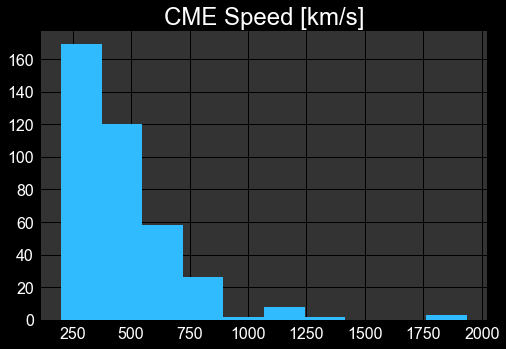

In [71]:
jedicdaw.hist(column = 'CME Speed [km/s]')

In [72]:
print('CME speed [km/s] Mean: {0} Min: {1} Max: {2}'.format(jedicdaw['CME Speed [km/s]'].mean(), jedicdaw['CME Speed [km/s]'].min(), jedicdaw['CME Speed [km/s]'].max()))

CME speed [km/s] Mean: 453.66494845360825 Min: 201.0 Max: 1936.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15d731358>]], dtype=object)

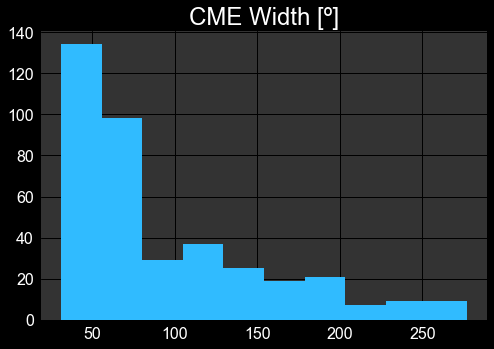

In [73]:
jedicdaw.hist(column = 'CME Width [º]')

In [74]:
print('CME Width [º] Mean: {0} Min: {1} Max: {2}'.format(jedicdaw['CME Width [º]'].mean(), jedicdaw['CME Width [º]'].min(), jedicdaw['CME Width [º]'].max()))

CME Width [º] Mean: 91.83505154639175 Min: 31.0 Max: 277.0


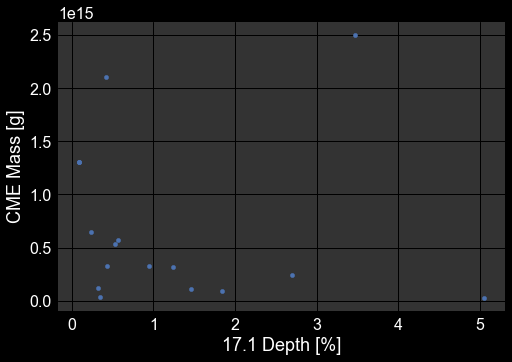

In [75]:
jedicdaw.plot.scatter(y='CME Mass [g]', x='17.1 Depth [%]')

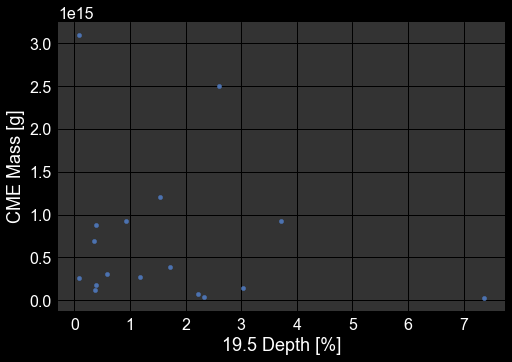

In [76]:
jedicdaw.plot.scatter(y='CME Mass [g]', x='19.5 Depth [%]')

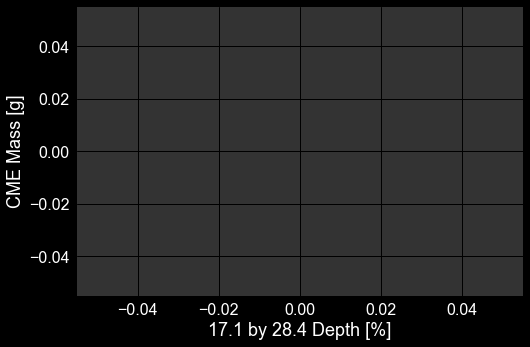

In [77]:
jedicdaw.plot.scatter(y='CME Mass [g]', x='17.1 by 28.4 Depth [%]')

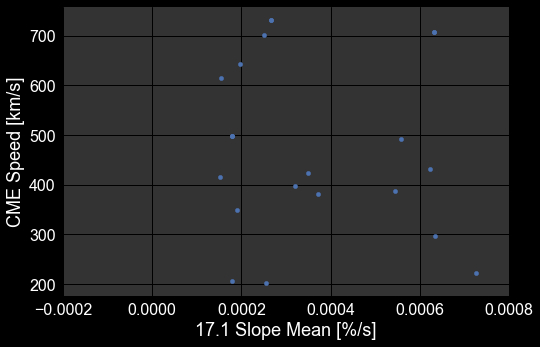

In [78]:
jedicdaw.plot.scatter(y='CME Speed [km/s]', x='17.1 Slope Mean [%/s]', xlim=[-2e-4, 8e-4])

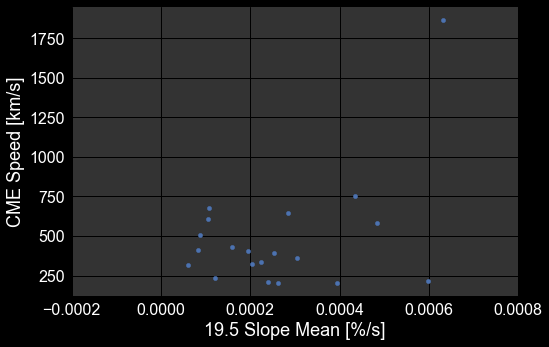

In [79]:
jedicdaw.plot.scatter(y='CME Speed [km/s]', x='19.5 Slope Mean [%/s]', xlim=[-2e-4, 8e-4])